In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

In [2]:
file_path = '../data/cleaned/IMDB_movies.csv'
df = pd.read_csv(file_path)
print("Read successfully")

Read successfully


In [3]:
df.head()

,rank,title,genres,budget,release_year,run_time,mpa,metascore,vote_count,rating
0,1,Frankenstein,"Drama, Fantasy, Horror, Sci-Fi",120000000.0,2025.0,149.0,R,77.0,132000.0,7.6
1,2,One Battle After Another,"Action, Crime, Drama, Thriller",130000000.0,2025.0,161.0,R,95.0,163000.0,8.0
2,3,The Running Man,"Action, Adventure, Sci-Fi, Thriller",110000000.0,2025.0,133.0,R,56.0,17000.0,6.7
3,4,Predator: Badlands,"Action, Adventure, Sci-Fi, Thriller",105000000.0,2025.0,107.0,PG-13,71.0,38000.0,7.5
4,5,Playdate,"Action, Comedy",17525.0,2025.0,93.0,PG-13,20.0,10000.0,5.5


# Câu 4
Ngân sách sản xuất có thực sự quyết định chất lượng và mức độ đón nhận của phim hay không?

- **Động lực**

Trong ngành công nghiệp điện ảnh, ngân sách sản xuất thường được xem là yếu tố then chốt quyết định chất lượng của một bộ phim, bao gồm chất lượng hình ảnh, kỹ xảo, đội ngũ sản xuất và mức độ quảng bá. 


- **Lợi ích** \
    Việc phân tích mối quan hệ giữa ngân sách và chất lượng phim mang lại nhiều lợi ích quan trọng:
    - Giúp xác định vai trò thực sự của **budget** trong việc dự đoán `rating` và `metascore`
    - Tránh việc đánh giá quá cao tác động của ngân sách khi xây dựng mô hình học máy
    - Là cơ sở để kết hợp thêm các yếu tố phi tài chính như thể loại phim, nội dung và đánh giá chuyên môn
    - Hỗ trợ xây dựng mô hình dự đoán có tính giải thích và độ tin cậy cao hơn

- **Những bên quan tâm**

    - Nhà sản xuất & hãng phim:
        - Quan tâm đến hiệu quả đầu tư (ROI)
        - Kết quả phân tích giúp tối ưu hóa việc phân bổ ngân sách thay vì chỉ tăng chi tiêu
    - Đạo diễn & đội ngũ sáng tạo:
        - Khẳng định vai trò của kịch bản, phong cách đạo diễn và chất lượng nội dung
        - Giảm áp lực phụ thuộc hoàn toàn vào ngân sách lớn
    - Nhà khoa học dữ liệu & nhóm nghiên cứu:
        - Hiểu rõ hơn tầm quan trọng của từng đặc trưng trong mô hình dự đoán
        - Nâng cao khả năng giải thích và phân tích kết quả mô hình
    - Khán giả & nhà đầu tư:
        - Có thêm cơ sở để đánh giá phim ngoài yếu tố ngân sách
        - Hỗ trợ ra quyết định đầu tư và lựa chọn phim một cách hợp lý hơn


## 1. Tiền xử lý

### 1.1 Xử lý missing

- Lập danh sách các feature cần phân tích

In [4]:
features = ['budget', 'metascore', 'vote_count', 'rating', 'release_year']

- Kiểm tra missing

In [5]:
df[features].isnull().sum()

budget          3404
metascore       2410
vote_count       412
rating           412
release_year     168
dtype: int64

- Xóa các hàng có ô bị missing

In [6]:
df.dropna(subset=['budget', 'vote_count', 'rating'], inplace=True)

In [7]:
df[features].isna().sum()

budget            0
metascore       687
vote_count        0
rating            0
release_year      0
dtype: int64

### 1.2 Phân nhóm

In [8]:
df_rq = df.copy()

Quan sát phân bố `release_year` cho thấy dữ liệu không phân bố đồng đều theo thời gian, với số lượng phim tăng mạnh sau năm 2000. Do đó, thay vì chia dữ liệu theo các khoảng thập kỷ cố định, nghiên cứu chia các bộ phim thành các **giai đoạn phát triển của ngành điện ảnh** như sau:

- **Early Cinema**: các phim phát hành trước năm 1980
- **Transition Era**: các phim phát hành từ năm 1981 đến 2000
- **Modern Cinema**: các phim phát hành từ năm 2001 trở đi




In [9]:
def assign_era(year):
    if year <= 1980:
        return "Early Cinema (≤1980)"
    elif year <= 2000:
        return "Transition Era (1981–2000)"
    else:
        return "Modern Cinema (≥2001)"

df_rq["era"] = df_rq["release_year"].apply(assign_era)

In [10]:
df_rq["era"].value_counts()

era
Modern Cinema (≥2001)         4320
Transition Era (1981–2000)    1597
Early Cinema (≤1980)           687
Name: count, dtype: int64

### 1.3 Xử lý budget

Để giảm ảnh hưởng của sự chênh lệch lớn về thang đo và các giá trị ngoại lai, ngân sách sản xuất được biến đổi bằng hàm log:

- `log_budget = log(budget)`


In [11]:
df_rq["log_budget"] = np.log(df_rq["budget"])


### 1.4 Xử lý vote_count

Để giảm ảnh hưởng của sự chênh lệch lớn về thang đo và các giá trị ngoại lai, ngân sách sản xuất được biến đổi bằng hàm log:

- `log_budget = log(budget)`




In [12]:
df_rq["log_vote_count"] = np.log(df_rq["vote_count"] + 1)

## 2. Phân tích

### 2.1 Tương quan **budget** với **metascore**

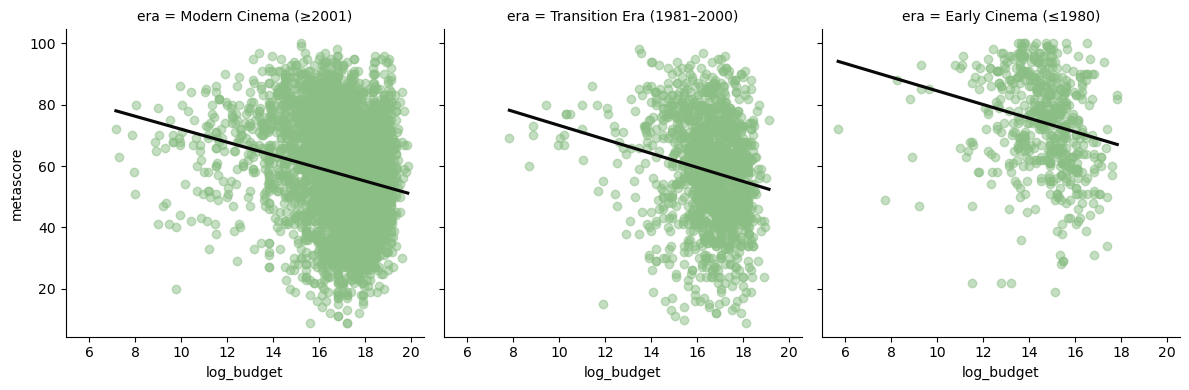

In [13]:
sns.lmplot(
    data=df_rq.dropna(subset=["metascore"]),
    x="log_budget",
    y="metascore",
    col="era",
    height=4,
    aspect=1,
    scatter_kws={"alpha": 0.5, "color": "#8ABE84"},  # dark blue
    line_kws={"color": "#0A0909"},  # teal
    ci=None
)
plt.show()


**Nhận xét**
- Trong cả ba giai đoạn (Early, Transition, Modern), mối quan hệ giữa log(budget) và metascore đều có xu hướng âm nhẹ.

- Ngân sách cao không đảm bảo metascore cao, cho thấy chi phí sản xuất không phải yếu tố quyết định chất lượng phê bình.

- Ở Early Cinema, nhiều phim ngân sách thấp vẫn đạt metascore cao, phản ánh vai trò lớn của yếu tố nghệ thuật.

- Trong Transition Era, xu hướng âm vẫn tồn tại nhưng yếu hơn, cho thấy giai đoạn chuyển tiếp về công nghệ và sản xuất.

- Modern Cinema có nhiều phim ngân sách rất lớn nhưng metascore phân tán rộng, cho thấy định hướng thương mại làm suy yếu mối liên hệ giữa ngân sách và chất lượng phê bình.

### 2.2 Tương quan **log_budget** và **log_vote_vount**

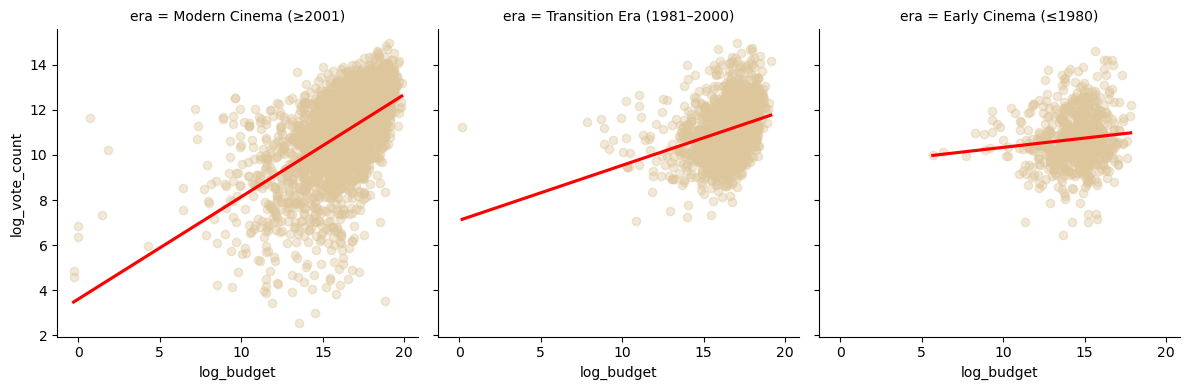

In [14]:
sns.lmplot(
    data=df_rq.dropna(subset=["vote_count"]),
    x="log_budget",
    y="log_vote_count",
    col="era",
    height=4,
    aspect=1,
    scatter_kws={"alpha":0.4, "color":"#DDC69C"},
    line_kws={"color":"red"},
    ci=None
)
plt.show()


**Nhận xét:**
- Ở cả ba giai đoạn, log(budget) có mối quan hệ dương với log(vote_count): ngân sách càng lớn thì mức độ quan tâm của khán giả (số lượt vote) càng cao.

- Modern Cinema (≥2001) thể hiện xu hướng dương mạnh nhất và mật độ điểm dày đặc, cho thấy ngân sách lớn giúp phim tiếp cận rộng rãi hơn nhờ marketing, franchise và phân phối toàn cầu.

- Transition Era (1981–2000) vẫn có quan hệ dương rõ ràng nhưng yếu hơn so với giai đoạn hiện đại.

- Early Cinema (≤1980) có xu hướng dương rất nhẹ, phản ánh hạn chế về hệ thống phát hành và đo lường mức độ quan tâm của khán giả thời kỳ này.

- Kết quả cho thấy ngân sách ảnh hưởng mạnh đến mức độ phổ biến (vote_count), đặc biệt trong điện ảnh hiện đại, khác với metascore – nơi ngân sách không đảm bảo chất lượng phê bình.

### 2.3 Tương quan **log_budget** và **rating**

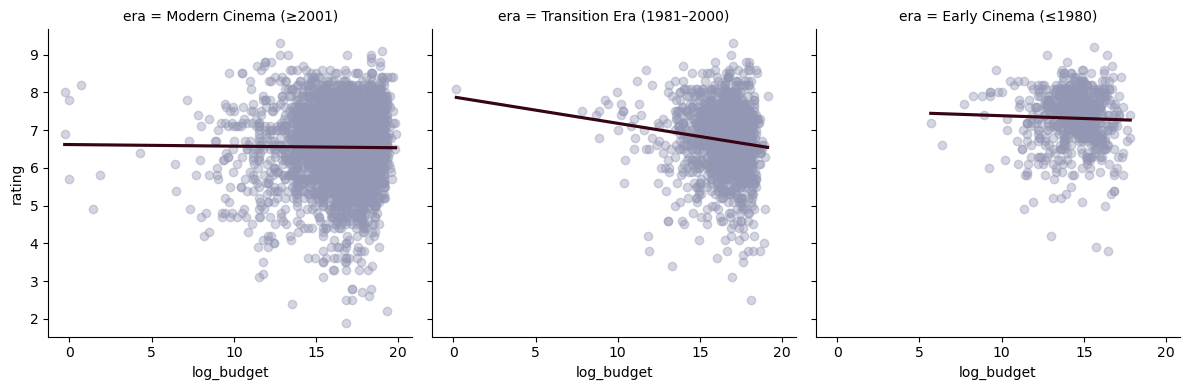

In [15]:
sns.lmplot(
    data=df_rq.dropna(subset=["rating"]),
    x="log_budget",
    y="rating",
    col="era",
    height=4,
    aspect=1,
    scatter_kws={"alpha":0.4, 'color': "#9397B3"},
    line_kws={"color":"#360414"},
    ci=None
)
plt.show()


**Nhận xét:**
- Trong cả ba giai đoạn, log(budget) hầu như không có mối quan hệ dương với rating.

- Các đường hồi quy gần như phẳng hoặc hơi âm, cho thấy tăng ngân sách không làm khán giả hài lòng hơn.

- Early Cinema (≤1980): rating ổn định, ít phụ thuộc vào ngân sách.

- Transition Era (1981–2000): xuất hiện xu hướng âm nhẹ; phim tốn kém hơn chưa chắc được đánh giá cao hơn.

- Modern Cinema (≥2001): ngân sách lớn tập trung nhiều nhưng rating phân tán mạnh, phản ánh định hướng thương mại hơn chất lượng cảm nhận.

---
#### **Kết luận**
- Ngân sách sản xuất không quyết định trực tiếp chất lượng phim khi đo bằng rating và metascore.

- Ngân sách có tác động rõ ràng đến mức độ đón nhận (vote_count), đặc biệt trong điện ảnh hiện đại, thông qua marketing và độ phủ truyền thông.

- Mối quan hệ giữa ngân sách và chất lượng đánh giá (rating, metascore) là yếu hoặc âm nhẹ trong mọi era.

- Ảnh hưởng của ngân sách thay đổi theo giai đoạn, và giảm dần trong Modern Cinema, nơi yếu tố thương mại chiếm ưu thế.